## Accenture - Supply Chain


In [2005]:
# Packaging management
import numpy as np
import pandas as pd
import csv 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
import math

# Data Preparation

In [2006]:
## Distance matrix preparation

## Read raw data from csv files
pd_cities_raw = pd.read_csv("datas/cities_data.csv" ,sep=";")

city_list_s = pd_cities_raw['city_from_name'].unique()
city_list_d = pd_cities_raw['city_to_name'].unique()
all_cities= list(set(city_list_s) | set(city_list_d))

city_dict = {all_cities[i]:i for i in range(0,len(all_cities))}
n_cities = len(all_cities)

distance_mat = [[0]*n_cities]*n_cities


for index, row in pd_cities_raw.iterrows():
    s = city_dict[row["city_from_name"]]
    d = city_dict[row["city_to_name"]]
    distance = row["distance"]
    distance_mat[s][d] = distance

In [2007]:
## Product Matrix

pd_products_raw = pd.read_csv("datas/product_attributes.csv", sep=",")


##dataframe quering example  !(return a string value)
# pd_products_raw.loc[pd_products_raw["product_id"]==1672707]["material_handling"].to_string(index=False)


In [2008]:
## Probability dictionary calculation
pd_orders_raw=pd.read_csv("datas/orders.csv",sep=";")

pd_orders_raw.loc[pd_orders_raw["origin_port"] == "BCN", "origin_port"] = "Barcelona"
pd_orders_raw.loc[pd_orders_raw["origin_port"] == "ATHENAS", "origin_port"] = "Athens"


cities_origin = pd_orders_raw['origin_port'].unique()
cities_hub = pd_orders_raw['logistic_hub'].unique()
cities_customer =  pd_orders_raw['customer'].unique()
pd_origin_count = pd_orders_raw.groupby(['origin_port', 'late_order']).size()
pd_hub_count = pd_orders_raw.groupby(['logistic_hub', 'late_order']).size()
pd_customer_count = pd_orders_raw.groupby(['customer', 'late_order']).size()

city_count_origin =  pd_orders_raw.groupby(['origin_port']).size()
city_count_hub = pd_orders_raw.groupby(['logistic_hub']).size()
city_count_customer = pd_orders_raw.groupby(['customer']).size()

delay_rate_origin = {all_cities[i]:0 for i in range(0,len(all_cities))}
delay_rate_hub = {all_cities[i]:0 for i in range(0,len(all_cities))}
delay_rate_customer = {all_cities[i]:0 for i in range(0,len(all_cities))}


origin_count_dict =  pd_orders_raw.groupby(['origin_port','late_order']).size().to_dict()
hub_count_dict =  pd_orders_raw.groupby(['logistic_hub','late_order']).size().to_dict()
customer_count_dict =  pd_orders_raw.groupby(['customer','late_order']).size().to_dict()

In [2009]:
for key, values in origin_count_dict:
    total = city_count_origin[key]
    if (values == True):
        true_count_origin = origin_count_dict[key,values]
        delay_rate_origin[key] = true_count_origin/total
print("origin city")
print(delay_rate_origin)
for key, values in hub_count_dict:
    total = city_count_hub[key]
    if (values == True):
        true_count_origin = hub_count_dict[key,values]
        delay_rate_hub[key] = true_count_origin/total
print("hub city")
print(delay_rate_hub)
for key, values in customer_count_dict:
    total = city_count_customer[key]
    if (values == True):
        true_count_origin = customer_count_dict[key,values]
        delay_rate_customer[key] = true_count_origin/total
print("destination city")
print(delay_rate_customer)

origin city
{'Malmö': 0, 'Lisbon': 0, 'Bucharest': 0, 'Venlo': 0, 'Turin': 0, 'Hamburg': 0, 'Berlin': 0, 'Hanover': 0, 'Milan': 0, 'Zaragoza': 0, 'Rome': 0, 'Amsterdam': 0, 'Marseille': 0, 'Naples': 0, 'Dusseldorf': 0, 'Prague': 0, 'Helsinki': 0, 'Barcelona': 0.2702263870848024, 'Vienna': 0, 'Munich': 0, 'Rotterdam': 0.16921047383841328, 'Budapest': 0, 'Lille': 0, 'Warsaw': 0, 'Bratislava': 0, 'Paris': 0, 'Lyon': 0, 'Madrid': 0, 'Stockholm': 0, 'Copenhagen': 0, 'Cologne': 0, 'Athens': 0.3741508954193759, 'Valencia': 0, 'Bremen': 0, 'Liege': 0, 'Porto': 0, 'Bordeaux': 0}
hub city
{'Malmö': 0, 'Lisbon': 0, 'Bucharest': 0, 'Venlo': 0.18738396624472572, 'Turin': 0, 'Hamburg': 0.20204841713221602, 'Berlin': 0, 'Hanover': 0, 'Milan': 0, 'Zaragoza': 0.3497337053005326, 'Rome': 0.2575441412520064, 'Amsterdam': 0, 'Marseille': 0, 'Naples': 0, 'Dusseldorf': 0.18381530595941845, 'Prague': 0, 'Helsinki': 0, 'Barcelona': 0, 'Vienna': 0, 'Munich': 0, 'Rotterdam': 0, 'Budapest': 0, 'Lille': 0.3595823

In [2010]:
threepl_list = pd_orders_raw['3pl'].unique()
procedures = pd_orders_raw['customs_procedures'].unique()

n3pl = len(threepl_list)
nprocedures= len(procedures)

dict_3pl = {threepl_list[i]:i for i in range(0,len(threepl_list))}
dict_procedures = {procedures[i]:i for i in range(0,len(procedures))}

pd_orders_raw['3pl'] = pd_orders_raw['3pl'].factorize()[0]
pd_orders_raw['customs_procedures'] = pd_orders_raw['customs_procedures'].factorize()[0]

pd_orders_raw

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order
0,366c7a3d298f,Rotterdam,0,0,Venlo,Marseille,1692723,583,True
1,45f906331e10,Rotterdam,1,1,Rome,Marseille,1644308,459,False
2,ac84a6e4af0f,Athens,0,1,Venlo,Paris,1684170,464,True
3,f5e98cb29790,Rotterdam,1,1,Lille,Milan,1620510,678,False
4,a9e7c9bee35b,Barcelona,0,1,Venlo,Berlin,1699372,353,False
...,...,...,...,...,...,...,...,...,...
114271,3f4b15fb770e,Rotterdam,0,1,Dusseldorf,Bordeaux,1681376,645,False
114272,d2e6978a38fd,Barcelona,1,2,Dusseldorf,Berlin,1676942,502,False
114273,b88babd5c7bd,Rotterdam,0,0,Dusseldorf,Rome,1692737,464,False
114274,b0b5c761613f,Barcelona,3,2,Dusseldorf,Munich,1699974,388,False


In [2011]:
# p_origin = pd_orders_raw['origin_port'].tolist()
# p_hub = pd_orders_raw['logistic_hub'].tolist()
# p_customer =  pd_orders_raw['customer'].tolist()

# i=0
# for item in p_origin:
#     p_origin[i] = delay_rate_origin[item]
#     i+=1

# i=0
# for item in p_hub:
#     if type(item) != str:
#         p_hub[i] = 0
#         i+=1
#     else: 
#         p_hub[i] = delay_rate_hub[item]
#         i+=1
        
# i=0
# for item in p_customer:
#     p_customer[i] = delay_rate_customer[item]
#     i+=1

In [2012]:
# pd_orders_raw["p_origin"] = p_origin
# pd_orders_raw["p_hub"] = p_hub
# pd_orders_raw["p_customer"] = p_customer
# pd_orders_raw

origins = pd_orders_raw['origin_port'].tolist()
hubs = pd_orders_raw['logistic_hub'].tolist()
customers =  pd_orders_raw['customer'].tolist()

total_distance = []
for i in range(len(origins)):
   if type(hubs[i]) != str:
       total_distance.append(distance_mat[city_dict[origins[i]]][city_dict[customers[i]]])
   else:
        a = distance_mat[city_dict[origins[i]]][city_dict[hubs[i]]]
        b = distance_mat[city_dict[hubs[i]]][city_dict[customers[i]]]
        total_distance.append(a+b)
        
pd_orders_raw["total_d"] = total_distance

In [2013]:
pd_products_raw.loc[len(pd_products_raw.index)] = [-1, 0, 6] 
pd_final = pd.DataFrame()
pd_final = pd.merge(pd_orders_raw, pd_products_raw, on="product_id")
pd_final["late_order"] = pd_final["late_order"].astype(int)

pd_final = pd_final.rename(columns = {"3pl":"threepl"})

[Text(0.5, 1.0, 'Countplot of lateorder')]

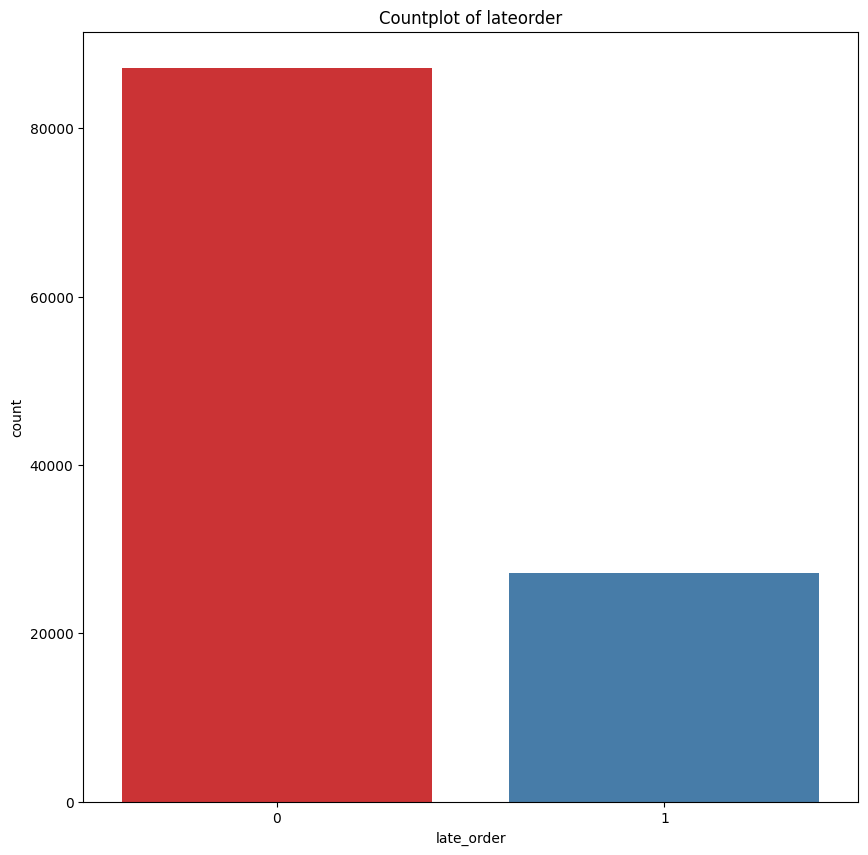

In [2014]:
sns.countplot(x = 'late_order', data= pd_final, palette = 'Set1').set(title = 'Countplot of lateorder')

In [2015]:
pd_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114276 entries, 0 to 114275
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   order_id            114276 non-null  object 
 1   origin_port         114276 non-null  object 
 2   threepl             114276 non-null  int64  
 3   customs_procedures  114276 non-null  int64  
 4   logistic_hub        113227 non-null  object 
 5   customer            114276 non-null  object 
 6   product_id          114276 non-null  int64  
 7   units               114276 non-null  int64  
 8   late_order          114276 non-null  int64  
 9   total_d             114276 non-null  float64
 10  weight              114276 non-null  int64  
 11  material_handling   114276 non-null  int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 11.3+ MB


## Training

In [2016]:
pd_final.dtypes


order_id               object
origin_port            object
threepl                 int64
customs_procedures      int64
logistic_hub           object
customer               object
product_id              int64
units                   int64
late_order              int64
total_d               float64
weight                  int64
material_handling       int64
dtype: object

In [2017]:
#pd_final = pd_final.drop(['product_id','order_id','origin_port', 'logistic_hub','customer'],axis=1)

In [2018]:
origin_port = pd.get_dummies(pd_final['origin_port'], drop_first=True)
threepl = pd.get_dummies(pd_final['threepl'], drop_first=True)
customs_procedures = pd.get_dummies(pd_final['customs_procedures'], drop_first=True)
logistic_hub = pd.get_dummies(pd_final['logistic_hub'], drop_first=True)
customer = pd.get_dummies(pd_final['customer'], drop_first=True)
material_handling = pd.get_dummies(pd_final['material_handling'], drop_first=True)

pd_final = pd_final.drop(['product_id','order_id','origin_port', 'logistic_hub','customer','threepl','customs_procedures','material_handling'],axis=1)
pd_final = pd.concat([pd_final,origin_port,threepl,customs_procedures,logistic_hub,customer,material_handling],axis=1)

In [2019]:
pd_final

,units,late_order,total_d,weight,Barcelona,Rotterdam,1,2,3,1,...,Stockholm,Turin,Valencia,Vienna,1,2,3,4,5,6
0,583,1,1091.6809,1778,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,385,0,1211.7994,1778,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,484,0,234.7418,1778,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,408,0,1473.7563,1778,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,526,0,1975.3037,1778,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,460,0,1211.7994,386,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
114272,471,0,773.7066,386,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
114273,581,0,807.2410,1131,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
114274,459,0,1211.7994,896,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [2020]:
lables = pd.DataFrame(pd_final['late_order'])
lables.late_order[lables.late_order ==True] = 1
lables.late_order[lables.late_order ==False] = 0

pd_final = pd_final.drop(['late_order'],axis=1)

In [2021]:
X_train, X_test, y_train, y_test = train_test_split(pd_final,lables, test_size = 0.8, random_state=0)

In [2022]:
logmodel = LogisticRegression(class_weight='balanced')
logmodel.fit(X_train,y_train)
prediction_log = logmodel.predict(X_test)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

In [2023]:
print(classification_report(y_test, prediction_log))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76     69766
           1       0.39      0.65      0.49     21655

    accuracy                           0.67     91421
   macro avg       0.63      0.67      0.62     91421
weighted avg       0.75      0.67      0.70     91421



In [2024]:
importance = list(logmodel.coef_.flatten())


columns = list(pd_final.columns)

removable = []
for i in range(len(importance)):
    if abs(importance[i])<0.1:
        removable.append(columns[i]) 
        
removable


importance_table = pd.DataFrame({"parameter": columns, "importance": importance })
importance_table.to_csv("importance.csv", index=False)

In [2025]:
## Retrain the data
pd_final = pd_final.drop(['units','total_d','weight'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(pd_final,lables, test_size = 0.6, random_state=0)
logmodel = LogisticRegression(class_weight='balanced')
logmodel.fit(X_train,y_train)
prediction_log = logmodel.predict(X_test)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [2026]:
print(classification_report(y_test, prediction_log))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74     52405
           1       0.37      0.64      0.46     16161

    accuracy                           0.65     68566
   macro avg       0.61      0.65      0.60     68566
weighted avg       0.74      0.65      0.68     68566



In [2027]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}
    
dtc = tree.DecisionTreeClassifier(random_state=0)

dtc.fit(X_train, y_train)

# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.7244406848875536
Precision: 0.36596370769985287
Recall: 0.23086442670626817
F1 Score: 0.28312338746395505
Cohens Kappa Score: 0.12325146757006555
Area Under Curve: 0.5562006064099265
Confusion Matrix:
 [[45941  6464]
 [12430  3731]]


/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Prediction using our model

In [2028]:
test = pd.read_csv("datas/test.csv",sep=";")
orders = test["order_id"].to_list()

In [2029]:
threepl_list = test['3pl'].unique()
procedures = test['customs_procedures'].unique()

test.loc[test["origin_port"] == "BCN", "origin_port"] = "Barcelona"
test.loc[test["origin_port"] == "ATHENAS", "origin_port"] = "Athens"
test = pd.merge(test, pd_products_raw, on="product_id")
test

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,weight,material_handling
0,0e364fa5c795,Rotterdam,v_002,CRF,Warsaw,Munich,1687644,477,1974,5
1,6c8c11251114,Rotterdam,v_002,CRF,Venlo,Barcelona,1687644,414,1974,5
2,81d3be5e1eff,Athens,v_002,DTD,Warsaw,Lyon,1687644,536,1974,5
3,870a9b65a1b5,Rotterdam,v_001,CRF,Dusseldorf,Berlin,1687644,535,1974,5
4,eff072956d66,Rotterdam,v_002,CRF,Rome,Milan,1687644,266,1974,5
...,...,...,...,...,...,...,...,...,...,...
28558,5e5aac335f95,Rotterdam,v_004,CRF,Rome,Porto,1690006,520,1375,5
28559,753fe21cc3cb,Athens,v_002,DTD,Rome,Milan,1697086,431,2009,2
28560,9a4166ebe45d,Rotterdam,v_004,CRF,Dusseldorf,Porto,1652604,495,547,4
28561,7115201bce91,Barcelona,v_003,DTP,Hamburg,Paris,1652604,434,547,4


In [2030]:
origins = test['origin_port'].tolist()
hubs = test['logistic_hub'].tolist()
customers =  test['customer'].tolist()



total_distance = []
for i in range(len(origins)):
   if type(hubs[i]) != str:
       total_distance.append(distance_mat[city_dict[origins[i]]][city_dict[customers[i]]])
   else:
        a = distance_mat[city_dict[origins[i]]][city_dict[hubs[i]]]
        b = distance_mat[city_dict[hubs[i]]][city_dict[customers[i]]]
        total_distance.append(a+b)
        
test["total_d"] = total_distance

In [2031]:
origin_port = pd.get_dummies(test['origin_port'], drop_first=True)
threepl = pd.get_dummies(test['3pl'], drop_first=True)
customs_procedures = pd.get_dummies(test['customs_procedures'], drop_first=True)
logistic_hub = pd.get_dummies(test['logistic_hub'], drop_first=True)
customer = pd.get_dummies(test['customer'], drop_first=True)
material_handling = pd.get_dummies(test['material_handling'], drop_first=True)
test = test.drop(['product_id','order_id','origin_port', 'logistic_hub','customer','3pl','customs_procedures','material_handling','units','units','total_d','weight'],axis=1)
test = pd.concat([test,origin_port,threepl,customs_procedures,logistic_hub,customer,material_handling],axis=1)

In [2032]:
#res = logmodel.predict(test)
res = dtc.predict(test)
submission = pd.DataFrame({"order_id": orders, "late_order": res })
submission.to_csv("submission_kaggle.csv", index=False)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
